##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
import DenseNet as Dense
importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# pool.close()

In [2]:
def Curve(x,a,b,c):
    return (a/(b+x)**c)

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    return(Models)

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['K']))):
            MSE.append(results[0])
            R2 .append(results[4])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            MSE.append(results[0])
            R2 .append(results[4])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
    MSE = np.asanyarray(MSE)
    R2 = np.asanyarray(R2)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    Yval = np.asanyarray(Yval)
    Yval = Yval.mean(axis=0)
    y_val = np.asanyarray(y_val)
    y_val = y_val.mean(axis=0)  
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)   
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'],R2)
    else:
        return(MSE,RST.Master,R2)
def TTV_Split(iteration,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=iteration)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=iteration)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,iteration,X_fill = X_fill,Memory=Memory))

In [3]:
FillVar = 'fch4'
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
FullModel = ['PPFD_Avg','AirTC_Avg','Sedge','VWC','Grass']
Runs,params = Dense.Params('Test',FillVar,MP=False)
print(params)

{'proc': 1, 'K': 3, 'epochs': 100, 'Y': 'fch4'}


In [4]:
Time = time.time()
Path = 'Data_Footprints_2018-06-12.csv'

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
def RunLoop(Runs):
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(FullModel,params,pool,plot=True)
        MSE = Results[0]
        R2 = Results[2]
        Runs.loc[Runs['N']==N,'MSE']=MSE
        Runs.loc[Runs['N']==N,'R2']=R2
        print(Runs.loc[Runs['N']==N])
    return(Runs)

Runs = RunLoop(Runs)

Using TensorFlow backend.


   N       MSE        R2
0  4  0.761233  0.460378
1  4  0.780160  0.263122
2  4  0.780715  0.306553
    N       MSE        R2
3  16  0.438185  0.689380
4  16  0.615336  0.418801
5  16  0.583484  0.481738
    N       MSE        R2
6  36  0.442584  0.686262
7  36  0.555755  0.475077
8  36  0.554720  0.507287
     N       MSE        R2
9   64  0.412185  0.707811
10  64  0.547513  0.482862
11  64  0.565759  0.497482
      N       MSE        R2
12  100  0.410607  0.708930
13  100  0.557922  0.473031
14  100  0.574644  0.489590


# The "Optimum" Sized Model

          MSE        R2        SD        SE
N                                          
4    0.774036  0.343351  0.011091  0.006403
16   0.545669  0.529973  0.094436  0.054523
36   0.517686  0.556209  0.065043  0.037552
64   0.508486  0.562718  0.083896  0.048437
100  0.514391  0.557184  0.090268  0.052116


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


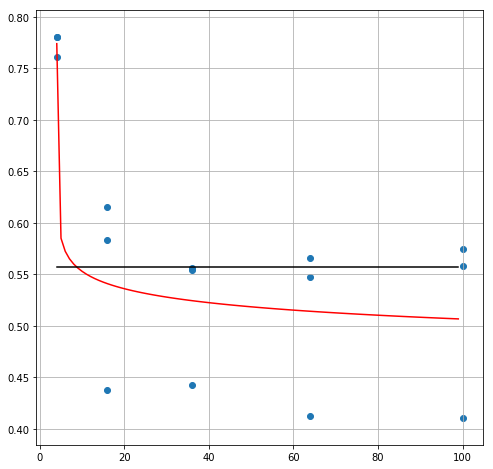

9 0.556922972577
84.1472852230072


In [5]:

Group = Runs.groupby('N').mean()
Group['SD'] = Runs[['N','MSE']].groupby('N').std()
Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

print(Group)
Min = Group.loc[Group['MSE']==Group['MSE'].min()]

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(Runs['N'],Runs['MSE'])
popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)
N = np.arange(Runs['N'].min(),Runs['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
plt.grid()
plt.show()
try:
    params['N']=N[Fit<Max].min()
except:
    params['N']=N[-1]
    pass
print(params['N'],Max)
print(time.time()-Time)

# Feature Identification

Dense3
Small - Batch
62 0.0994252727705
831.9313259124756
50 - Batch Size
42 0.103650333763
569.2546825408936
100 - Batch Size
38 0.113645573082
294.677371263504
Huge Batch
75 0.164365854341
359.2456679344177

Dense
100 - Batch Size
35 0.121937476336
272.4163167476654
Huge Batch
75 0.164325778396
222.42347693443298

In [6]:
Scores = Runs[['MSE','R2']].reset_index(drop=True)
Scores = (Scores.iloc[0:params['K']])*0
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)

Results = RunReps(FullModel,params,pool)

MSE = Results[0]
R2 = Results[2]
mean,std = MSE.mean(),MSE.std()
CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
Scores['MSE']=MSE#mean
Scores['R2']=R2#.mean()

ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns['Model: '+'+'.join(FullModel)]=ModelRuns['TempFill']
ModelRuns=ModelRuns.drop('TempFill',axis=1)
print(Scores)

        MSE        R2  Level  Key                               Model
0  0.517899  0.632872      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
1  0.630620  0.404366      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
2  0.627360  0.442766      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass


In [7]:
for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    Values = []
    Names = []
    for i,model in enumerate(Models):
        level = len(model)
        key = str(level)+'_'+str(i)
        Name = '+'.join(model)
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+Name
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        R2 = Results[2]
        d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
        score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
        Scores = Scores.append(score,ignore_index=True)
        print(Scores.loc[Scores['Key']==key])
        ModelRuns['Model: '+'+'.join(model)] = Results[1]    
    Group = Scores.groupby('Key').agg({'Model': 'first', 
                                            'Level': 'first', 
                                            'MSE': 'mean', 
                                            'R2': 'mean'})#.reset_index()#mean()  
    Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
    Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]
    Best = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
    print(Best)
    

Level:  1
   Key  Level       MSE     Model        R2
3  1_0      1  1.381583  PPFD_Avg  0.020625
4  1_0      1  1.034269  PPFD_Avg  0.023110
5  1_0      1  1.126345  PPFD_Avg -0.000443
   Key  Level       MSE      Model        R2
6  1_1      1  1.272242  AirTC_Avg  0.098135
7  1_1      1  0.977873  AirTC_Avg  0.076378
8  1_1      1  1.101062  AirTC_Avg  0.022014
    Key  Level       MSE  Model        R2
9   1_2      1  1.158751  Sedge  0.178586
10  1_2      1  0.965853  Sedge  0.087731
11  1_2      1  1.034381  Sedge  0.081242
    Key  Level       MSE Model        R2
12  1_3      1  1.278030   VWC  0.094032
13  1_3      1  1.032850   VWC  0.024450
14  1_3      1  1.032039   VWC  0.083322
    Key  Level       MSE  Model        R2
15  1_4      1  1.325140  Grass  0.060636
16  1_4      1  1.008809  Grass  0.047158
17  1_4      1  1.023557  Grass  0.090856
['Sedge']
Level:  2
    Key  Level       MSE           Model        R2
18  2_0      2  0.997546  PPFD_Avg+Sedge  0.292861
19  2_0     

                                  Model  Level       MSE        R2        SD  \
Key                                                                            
1_2                               Sedge      1  1.052995  0.115853  0.097787   
2_2                           Sedge+VWC      2  0.687405  0.413219  0.062756   
3_2                     Sedge+VWC+Grass      3  0.633834  0.459024  0.048805   
4_1           AirTC_Avg+Sedge+VWC+Grass      4  0.656748  0.442549  0.015686   
5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass      5  0.591960  0.493335  0.064159   

           SE  
Key            
1_2  0.056457  
2_2  0.036232  
3_2  0.028178  
4_1  0.009056  
5_0  0.037042  
                                Model  Level      MSE        R2        SD  \
4  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass      5  0.59196  0.493335  0.064159   

         SE  
4  0.037042  


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


   N       MSE        R2
0  4  0.761202  0.460400
1  4  0.780136  0.263145
2  4  0.776743  0.310081
    N       MSE        R2
3  16  0.438092  0.689446
4  16  0.615323  0.418814
5  16  0.583408  0.481805
    N       MSE        R2
6  36  0.439593  0.688382
7  36  0.555644  0.475182
8  36  0.554845  0.507175
     N       MSE        R2
9   64  0.412523  0.707571
10  64  0.547332  0.483033
11  64  0.565409  0.497792
      N       MSE        R2
12  100  0.410354  0.709109
13  100  0.557962  0.472993
14  100  0.574793  0.489458
          MSE        R2        SD        SE
N                                          
4    0.774036  0.343351  0.011091  0.006403
16   0.545669  0.529973  0.094436  0.054523
36   0.517686  0.556209  0.065043  0.037552
64   0.508486  0.562718  0.083896  0.048437
100  0.514391  0.557184  0.090268  0.052116
9


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


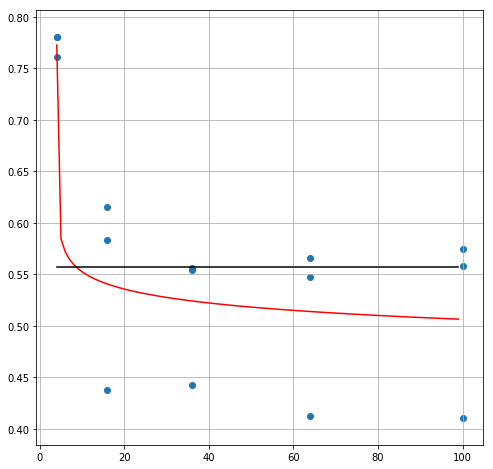

9


In [8]:
Group = Scores.groupby('Key').agg({'Model': 'first', 
                                        'Level': 'first', 
                                        'MSE': 'mean', 
                                        'R2': 'mean'})#.reset_index()#mean()  
Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
Min = Group.loc[Group['Level']==level]

Levels = Group.groupby('Level').min()
Sub=Group[Group['MSE'].isin(Levels['MSE'].values)]
print(Sub)
Sub.sort_values('Level',inplace=True)
Sub = Sub.loc[Sub['Level']>=1]
Sub.reset_index(inplace=True,drop=True)
Min = Sub.loc[Sub['MSE']==Sub['MSE'].min()]
Parsimony = (Sub.loc[Sub['MSE']<(Min['MSE'].values+Min['SE'].values)[0]])
Parsimony = Parsimony.loc[Parsimony['Level']==Parsimony['Level'].min()]
print(Parsimony)
Best = Parsimony['Model'].values


def Curve(x,a,b,c):
    return (a/(b+x)**c)

N = Runs['N']
NRuns = Runs*0
NRuns['N']=N

model = Best[0].split('+')
NRuns = RunLoop(NRuns)
Group = Runs.groupby('N').mean()
Group['SD'] = Runs[['N','MSE']].groupby('N').std()
Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

print(Group)
Min = Group.loc[Group['MSE']==Group['MSE'].min()]

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(Runs['N'],Runs['MSE'])
popt, pcov = curve_fit(Curve, NRuns['N'].values, NRuns['MSE'].values)

N = np.arange(NRuns['N'].min(),NRuns['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
try:
    params['N']=N[Fit<Max].min()
except:
    params['N']=N[-1]
    pass
print(params['N'])
plt.grid()
plt.show()
print(params['N'])

In [9]:
level = 0#len(Best)
print(Best)
key = '0_'+str(params['N'])
Name = '+'.join(Best)
NewRow = Scores.iloc[-1].copy()
NewRow['Model'] = 'BestModel: '+Name
Results = RunReps(model,params,pool)
MSE = Results[0]
for mse in MSE:
    Names.append(Name)
    Values.append(mse)
mean,std = MSE.mean(),MSE.std()
CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
R2 = Results[2]
d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
Scores = Scores.append(score,ignore_index=True)
Scores = Scores.append(score,ignore_index=True)
ModelRuns['BestModel: '+'+'.join(model)] = Results[1] 
print(params['N'])

['PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass']
9


In [10]:
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
ModelRuns.to_csv('GapFilled'+FillVar+'.csv')

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)

339.16507363319397
